In [238]:
import numpy as np
import nengo
from nengolib.signal import s, z
from nengo.utils.numpy import rmse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [239]:
def get_signals(
    signal_type,
    network_seed=1,
    sim_seed=1,
    freq=1,
    signal_seed=1,
    t_transient=1.0,
    t_final=1.0,
    max_freq=1,
    rms=1,
    tau=0.1,
    dt=0.001):

    with nengo.Network(seed=network_seed) as network:
        if signal_type == 'sinusoids':
            stim = nengo.Node(lambda t: 
                np.cos(freq * (t-t_transient)))
        elif signal_type == 'white_noise':
            stim = nengo.Node(nengo.processes.WhiteSignal(
                period=t_final, high=max_freq, rms=rms, seed=signal_seed, y0=0))
        integ = nengo.Node(size_in=1)
        nengo.Connection(stim, integ, synapse=1/s)
        p_stim = nengo.Probe(stim, synapse=None)
        p_integ = nengo.Probe(integ, synapse=None)
    with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
        sim.run(t_final)
    transient = np.array(0.0 * np.arange(0, t_transient+dt, dt))
    stimulus = np.hstack((transient, sim.data[p_stim][:,0]))
    integral = np.hstack((transient, sim.data[p_integ][:,0]))
    norm_stimulus = np.max(np.abs(stimulus))
    norm_integral = np.max(np.abs(integral))
    stimulus /= norm_stimulus
    integral /= norm_integral
    transform = norm_stimulus / norm_integral

    return stimulus, integral, transform

In [240]:
def make_network(
    pre_neurons=100,
    bio_neurons=100,
    tau=0.1,
    dt=0.001,
    min_rate=150,
    max_rate=200,
    radius=1,
    dim=1,
    pre_seed=1,
    bio_seed=2,
    conn_seed=3,
    network_seed=4,
    sim_seed=5,
    post_seed=6,
    inter_seed=7,
    conn2_seed=9,
    conn3_seed=10,
    bio_type=nengo.LIF(),
    inter_type=nengo.LIF(),
    signal=[],
    integral=[],
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((100, 1)),
    d_feedback=np.zeros((100,1)),
    d_inter=np.zeros((100,1)),
    H_ff=nengo.Lowpass(tau)):

    """
    Define the network
    """
    with nengo.Network(seed=network_seed) as network:
        stim = nengo.Node(lambda t: signal[int(t/dt)])
        integ = nengo.Node(lambda t: integral[int(t/dt)])
        pre = nengo.Ensemble(
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre')
        bio = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=bio_type,
            radius=radius,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            label='bio')
        pre_inter = nengo.Ensemble(  # currently unused
            n_neurons=pre_neurons,
            dimensions=dim,
            seed=pre_seed,
            neuron_type=nengo.LIF(),
            radius=radius,
            label='pre_inter')
        inter = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            neuron_type=inter_type,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            label='inter')
        lif = nengo.Ensemble(
            n_neurons=bio_neurons,
            dimensions=dim,
            seed=bio_seed,
            max_rates=nengo.dists.Uniform(min_rate, max_rate),
            radius=radius,
            neuron_type=nengo.LIF(),
            label='lif')
        oracle = nengo.Node(size_in=dim)
        temp = nengo.Node(size_in=dim)
        temp2 = nengo.Node(size_in=dim)

#         recurrent_solver = OracleSolver(decoders_bio = d_feedback)
        ff_solver = nengo.solvers.NoSolver(d_feedforward)
        fb_solver = nengo.solvers.NoSolver(d_feedback)
        inter_solver = nengo.solvers.NoSolver(d_inter)

        nengo.Connection(stim, pre, synapse=None)
        pre_bio = nengo.Connection(pre, bio,
            seed=conn_seed,
            synapse=tau,
            transform=T_pre_bio)
        bio_bio = nengo.Connection(bio, bio,
            seed=conn2_seed,
            synapse=tau,
            solver=fb_solver,
            transform=T_bio_bio)

        pre_lif = nengo.Connection(pre, lif,
            synapse=tau,
            transform=T_pre_lif)
        nengo.Connection(lif, lif,
            synapse=tau)

        stim_oracle = nengo.Connection(stim, oracle,
            synapse=tau,  
            transform=T_stim_oracle) # connection for training H(s) w/ feedforward pass
        integ_oracle = nengo.Connection(integ, oracle,
            synapse=None,  
            transform=T_integ_oracle) # connection for training d_feedback w/ feedback pass 

        integ_inter = nengo.Connection(integ, inter,  # no H(s)
            seed=conn3_seed,
            synapse=None)
        nengo.Connection(inter, bio,
            seed=conn3_seed,
            synapse=tau,
            transform=T_inter_bio,
            solver=inter_solver)  

        conn_lif = nengo.Connection(lif, temp, synapse=tau)
        conn_inter = nengo.Connection(inter, temp2, synapse=tau)

        probe_bio_spikes = nengo.Probe(bio.neurons, 'spikes')
        probe_lif_activity = nengo.Probe(lif.neurons, 'spikes', synapse=tau)
        probe_bio_activity = nengo.Probe(bio.neurons, 'spikes', synapse=H_ff)
        probe_oracle = nengo.Probe(oracle, synapse=H_ff)
        probe_bio = nengo.Probe(bio, synapse=tau, solver=ff_solver)
        probe_lif = nengo.Probe(lif, synapse=tau)
        probe_inter = nengo.Probe(inter, synapse=tau, solver=inter_solver)
        probe_inter_activity = nengo.Probe(inter.neurons, 'spikes', synapse=tau)
        probe_inter_spikes = nengo.Probe(inter.neurons, 'spikes', synapse=None)
        probe_pre = nengo.Probe(pre, synapse=tau)
        probe_integ = nengo.Probe(integ, synapse=None)

    network.conn_lif = conn_lif
    network.conn_inter = conn_inter
    network.bio_bio = bio_bio
    network.stim = stim
    network.integ = integ
    network.pre_bio = pre_bio
    network.pre_lif = pre_lif
    network.stim_oracle = stim_oracle
    network.integ_oracle = integ_oracle
    network.integ_inter = integ_inter
    network.probe_bio_spikes = probe_bio_spikes
    network.probe_bio_activity = probe_bio_activity
    network.probe_oracle = probe_oracle
    network.probe_bio = probe_bio
    network.probe_lif = probe_lif
    network.probe_lif_activity = probe_lif_activity
    network.probe_inter = probe_inter
    network.probe_inter_activity = probe_inter_activity
    network.probe_inter_spikes = probe_inter_spikes
    network.probe_pre = probe_pre
    network.probe_integ = probe_integ

    return network

In [241]:
def run_plot(network, t_transient, t_run, dt, sim_seed):
    
    with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
        sim.run(t_transient + t_test)
    
    times = sim.trange()[int(t_transient/dt):]
    xhat_bio = sim.data[network.probe_bio][int(t_transient/dt):]
    xhat_lif = sim.data[network.probe_lif][int(t_transient/dt):]
    xhat_inter = sim.data[network.probe_inter][int(t_transient/dt):]
    x_integ = sim.data[network.probe_integ][int(t_transient/dt):]
    target = sim.data[network.probe_oracle][int(t_transient/dt):]
    rmse_bio = rmse(xhat_bio, target)
    rmse_lif = rmse(xhat_lif, target)

    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.plot(times, xhat_bio, label='bio (test), rmse=%.5f' % rmse_bio)
    ax.plot(times, xhat_lif, label='lif, rmse=%.5f' % rmse_lif)
    # ax.plot(times, xhat_inter, label='inter')
    # ax.plot(times, x_integ, label='integ')
    ax.plot(times, target, label='target')
    ax.set(xlabel='time (s)', ylabel='$\hat{x}(t)$')
    ax.legend()
    plt.show()

# Testing

### Basic parameters

In [242]:
pre_neurons = 100
bio_neurons = 100
tau = 0.1
dt = 0.001
min_rate = 150
max_rate = 200
radius = 1
dim = 1
reg = 0.01
cutoff = 0.1
pre_seed = 1
bio_seed = 2
conn_seed = 3
network_seed = 4
sim_seed = 5
post_seed = 6
inter_seed = 7
conn2_seed = 9
conn3_seed = 10
bio_type =  nengo.LIF() # BahlNeuron() # nengo.AdaptiveLIF(tau_n=.01, inc_n=.05)
inter_type = nengo.LIF() # BahlNeuron() # nengo.AdaptiveLIF(tau_n=.01, inc_n=.05)

### Train cos(t), test cos(t)

In [243]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'sinusoids'
seed_train = 3
seed_test = 2

signal_train, integral_train, transform_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, transform_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_train = tau * transform_train
scale_pre_test = tau *transform_test

In [244]:
network = make_network(
    pre_neurons,
    bio_neurons,
    tau,
    dt,
    min_rate,
    max_rate,
    radius,
    dim,
    pre_seed,
    bio_seed,
    conn_seed,
    network_seed,
    sim_seed,
    post_seed,
    inter_seed,
    conn2_seed,
    conn3_seed,
    bio_type,
    inter_type,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

### Compute d_feedforward and d_inter using (a) evaluation points or (b) oracle method

In [245]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


In [246]:
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_feedforward_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

### Feedback inter spikes to bio using d_inter_eval_points, readout using d_feedforward_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


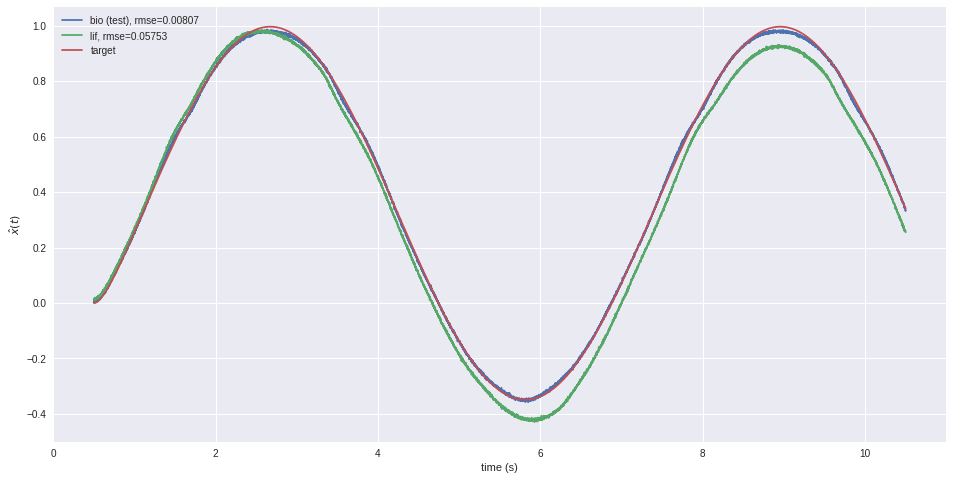

In [247]:
network = make_network(
    pre_neurons,
    bio_neurons,
    tau,
    dt,
    min_rate,
    max_rate,
    radius,
    dim,
    pre_seed,
    bio_seed,
    conn_seed,
    network_seed,
    sim_seed,
    post_seed,
    inter_seed,
    conn2_seed,
    conn3_seed,
    bio_type,
    inter_type,
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_eval_points,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Feedback inter spikes to bio using d_inter_eval_points, readout bio using d_feedforward_oracle

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


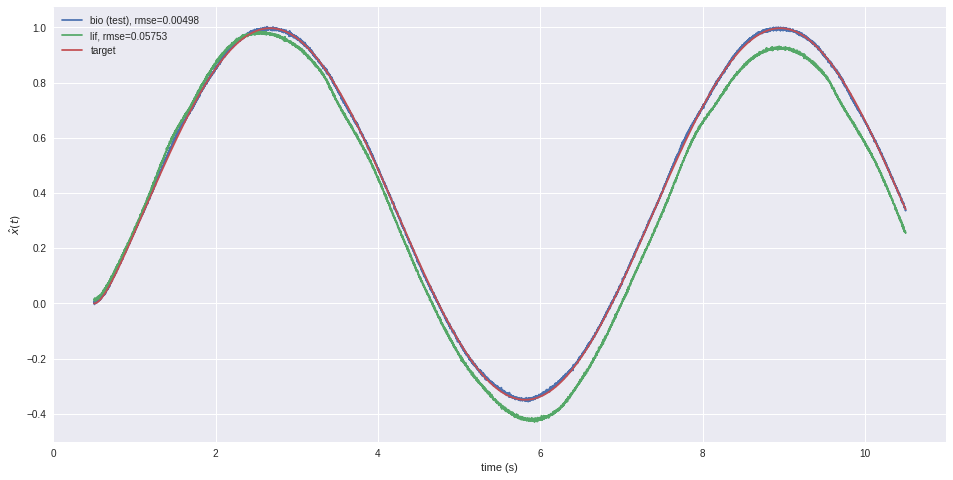

In [248]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_feedforward_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_eval_points,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Feedback inter spikes to bio using d_inter_oracle, readout bio using d_feedforward_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


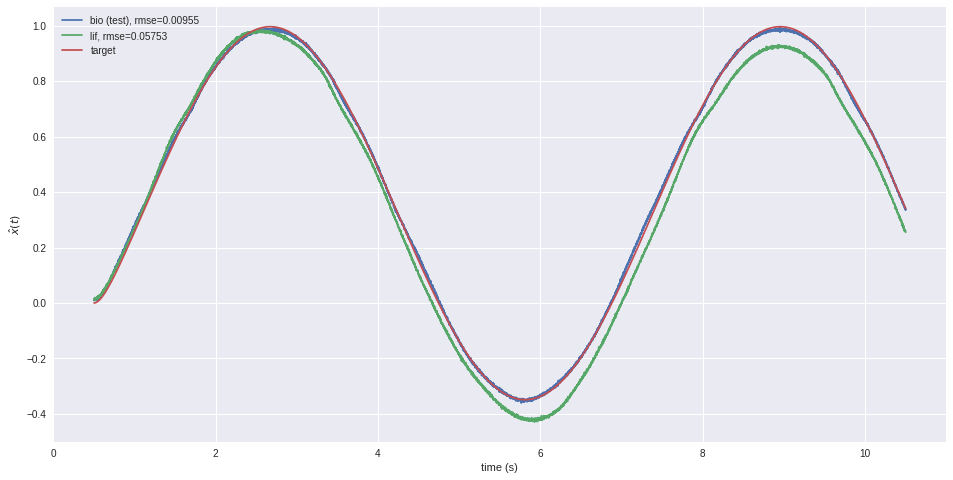

In [249]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Feedback inter spikes to bio using d_inter_oracle, readout bio using d_feedforward_oracle

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


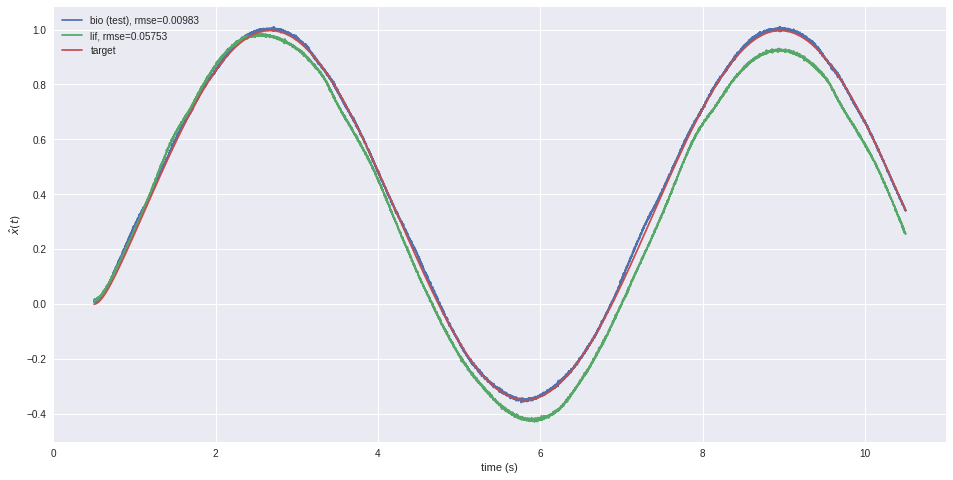

In [250]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_feedforward_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Train cos(t), test white_noise

In [251]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'sinusoids'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, transform_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, transform_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_train = tau * transform_train
scale_pre_test = tau *transform_test

In [252]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

In [253]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


### Compute decoders from the cos(t) training signal

In [254]:
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_feedforward_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

### Feedback inter spikes to bio using d_inter_oracle, readout bio using d_feedforward_oracle

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


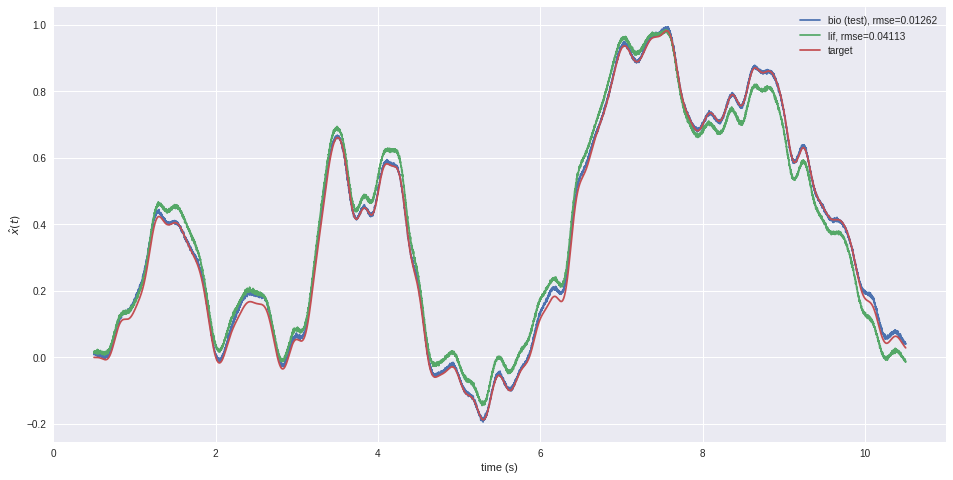

In [255]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_feedforward_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Seems like feeding back training spikes that are weighted by decoders computed with the oracle method (d_inter_oracle) CAN produce a stable integrator. Now the question is, can we use those same weights on the actual recurrent bio spikes to produce a stable integrator?

### Compute one final set of readout decoders, given d_inter=d_inter_oracle and d_fb=none

In [256]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_feedforward_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_train_spikes = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


Very accurate feedforward decoding. Now test whether any of the decoders computed in this section serve as effective d_fb when training spikes are removed.

# Remove training spikes, feedback bio spikes

### feedback bio spikes with d_fb = d_feedforward_eval_points, readout with d_ff=d_feedforward_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


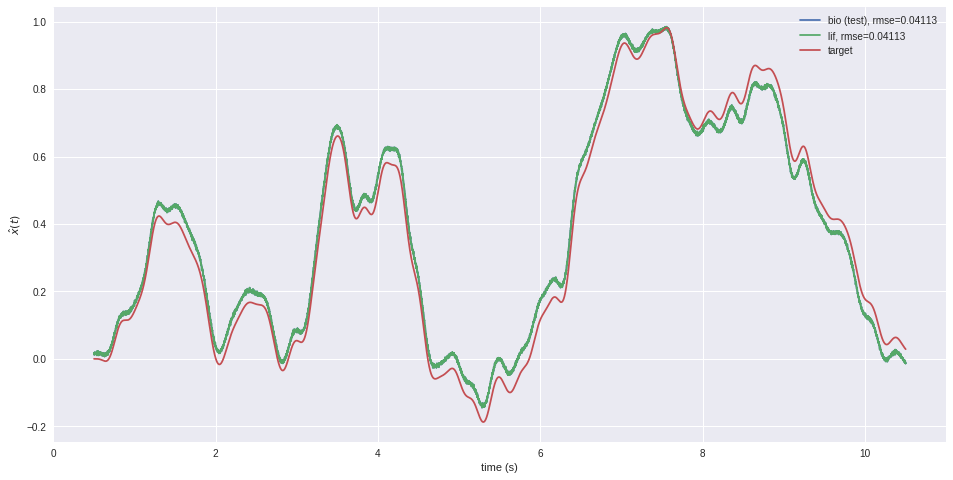

In [258]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=d_feedforward_eval_points,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Identical behavior, as expected given that all connections are computed with static decoders

### feedback bio spikes with d_fb = d_inter_eval_points, readout with d_ff=d_feedforward_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


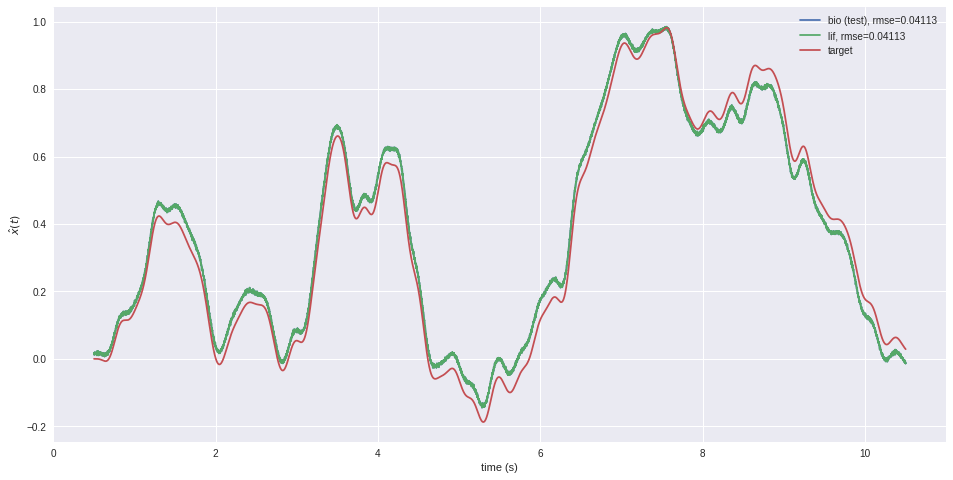

In [259]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=d_inter_eval_points,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Same as above, because inter is constructed to be identical to "bio" when bio_type = inter_type

### Readout bio with d_ff = d_ff_oracle_train_spikes, using d_fb = d_inter_eval_points

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


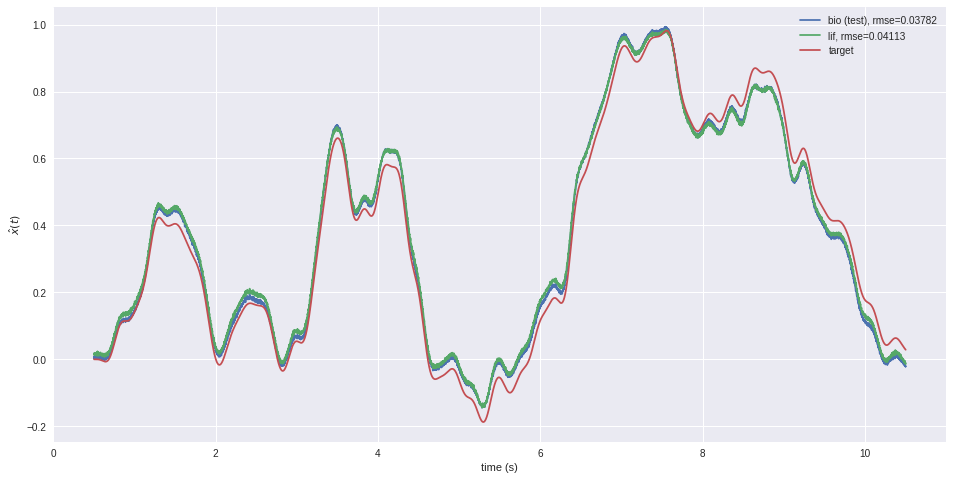

In [261]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_train_spikes,
    d_feedback=d_inter_eval_points,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

d_ff_oracle_train_spikes continues to be an effecitive readout decoder in the recurrent case. Now begin substituting the oracle-computed decoders into d_fb.

### Feedback bio spikes with d_fb = d_ff = d_ff_oracle_train_spikes

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


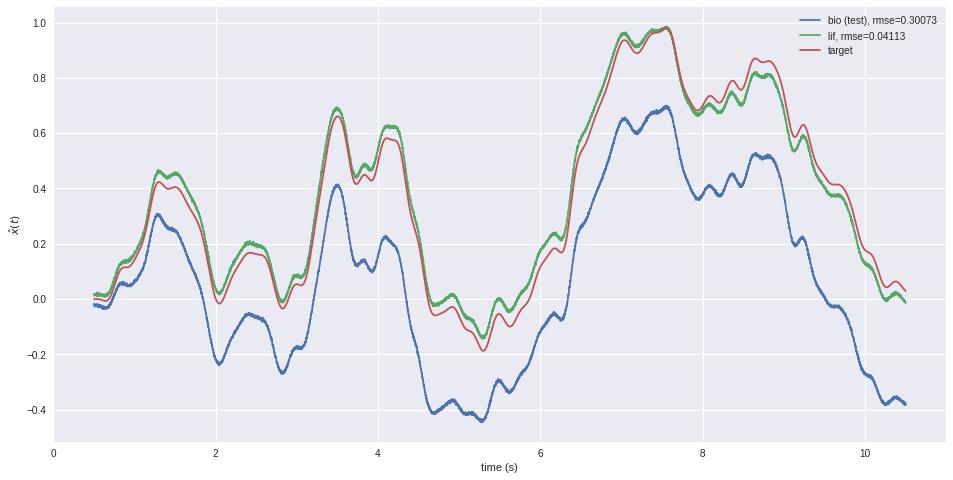

In [283]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_train_spikes,
    d_feedback=d_ff_oracle_train_spikes,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


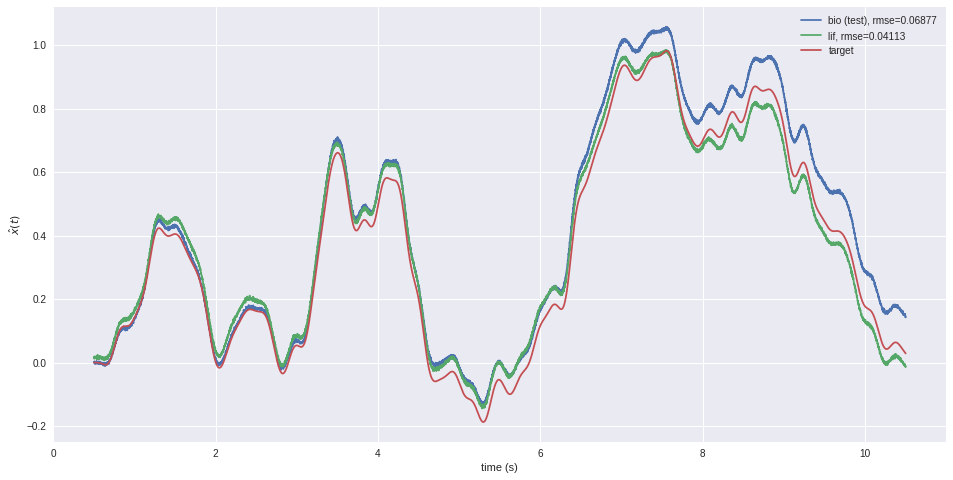

In [286]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_train_spikes,
    d_feedback=d_feedforward_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Seems like using decoders calculated from the oracle method in a feedforward network performs worse than the standard nengo decoders. This is odd, since using d_ff_oracle_train_spikes to readout bio's activities produces a good state estimate in the feedforward case. For some reason, d_ff_oracle (computed in the feedforward network) performs better than d_ff_oracle_train_spikes (computed in the recurrent network)

# Switch to ALIFs

In [287]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


### Feedback inter spikes to bio using d_inter_oracle, compute new d_ff_oracle_2 given this recurrence

In [288]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_2 = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


### Test performance of d_fb = d_ff_oracle vs d_fb = d_ff_oracle_2

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


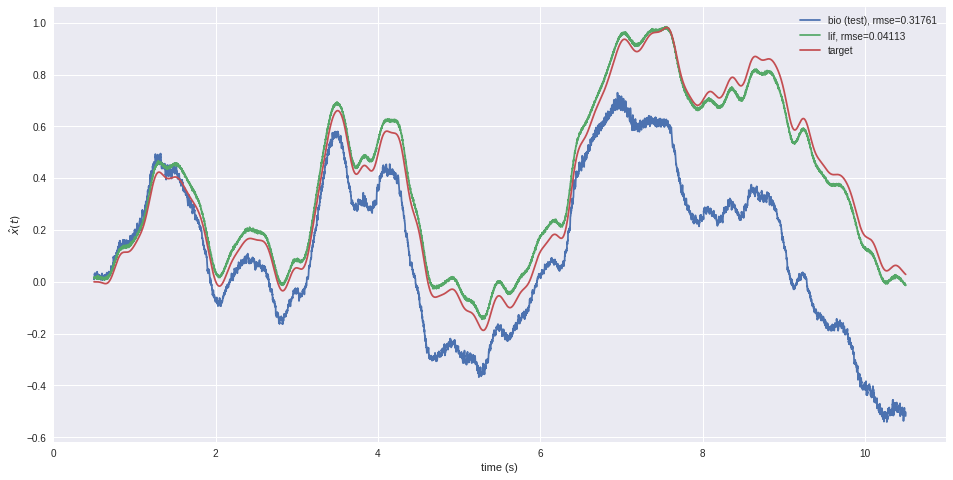

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


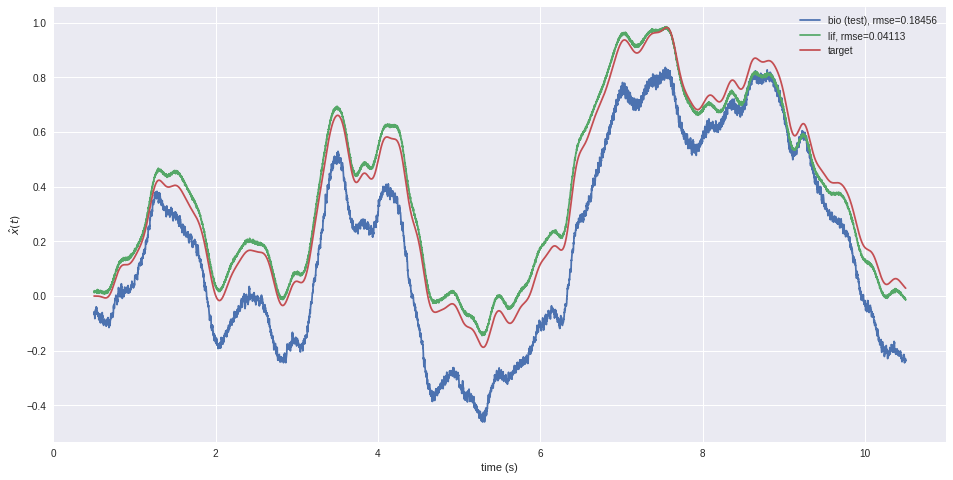

In [289]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Interestingly, here the d_ff_oracle_2, computed from the recurrent spikes, outperforms d_ff_oracle, computed from the feedforward spikes.

### Test on new white_noise signal

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


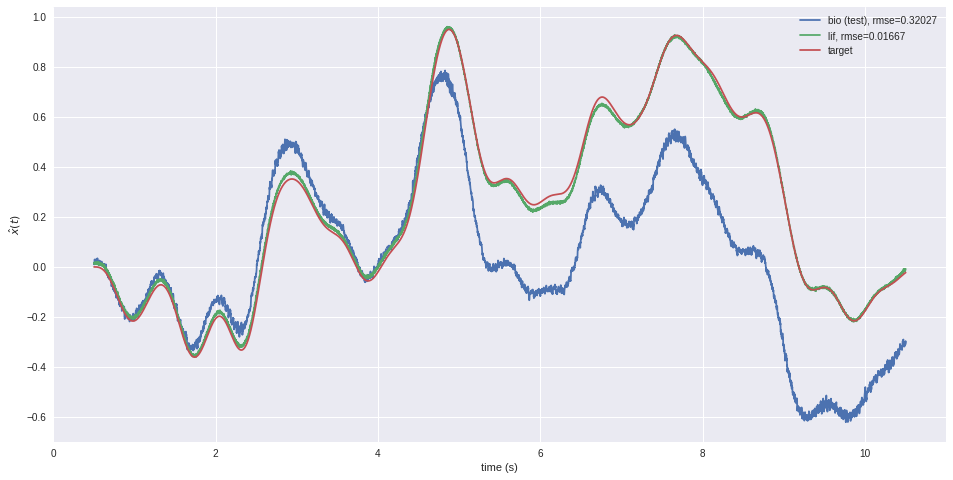

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


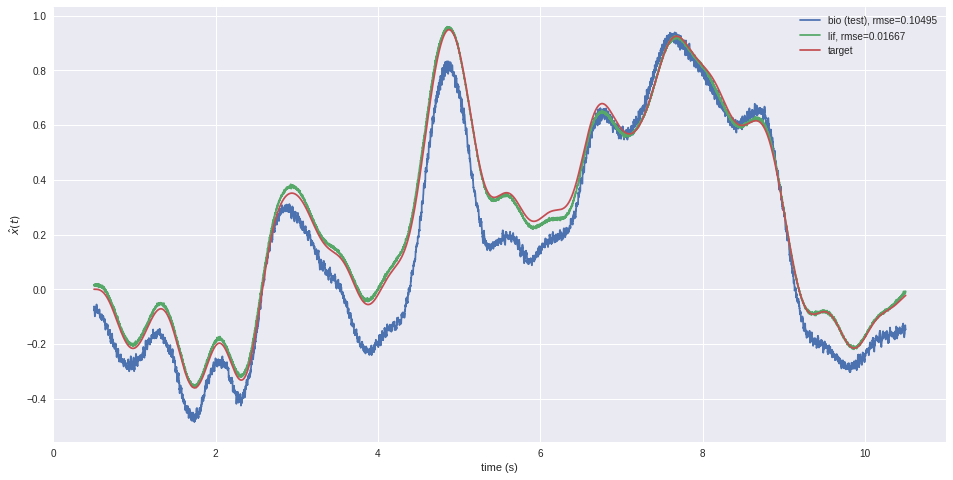

In [293]:
freq = 1
max_freq = 2
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_test = 'white_noise'
seed_test = 1

signal_test_2, integral_test_2, transform_test_2 = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_test_2 = tau *transform_test_2

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff_oracle_2,
    d_feedback=d_ff_oracle_2,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

d_ff_oracle_2 again outperforms d_ff_oracle

# Add in training for readout filters and decoders

In [294]:
from pathos import multiprocessing as mp
from nengolib.signal import LinearSystem
import nengolib
import copy

In [295]:
def build_filter(zeros, poles):
    """ create the transfer function from the passed constants to serve as the filter """
    built_filter = LinearSystem((zeros, poles, 1.0))
    built_filter /= built_filter.dcgain
    return built_filter

In [296]:
def train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_final,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    bio_probe,  # probe of bioneuron activity (filtered spikes)
    target_probe):

    def evaluate(inputs):
        network=inputs[0]
        zeros = inputs[1][0]
        poles = inputs[1][1]
        bio_probe = inputs[2][0]
        target_probe = inputs[2][1]
        """
        ensure stim outputs the training signal and the bio/alif are assigned
        their particular readout filters, as well as other filters that have been
        trained already (these can't be fed into pool.evaluate() without _paramdict errors)
        """
        filt = build_filter(zeros, poles)
        with network:
            bio_probe.synapse = filt
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        if np.sum(act_bio) > 0:
            d_bio = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
        else:
            d_bio = np.zeros((act_bio.shape[1], target.shape[1]))
        xhat_bio = np.dot(act_bio, d_bio)
        rmse_bio = rmse(target, xhat_bio)
        return rmse_bio

    def get_decoders(inputs, plot=False):
        network=inputs[0]
        zeros = inputs[1]
        poles = inputs[2]
        bio_probe = inputs[3]
        target_probe = inputs[4]
        """
        ensure stim outputs the training signal and the bio/alif are assigned
        their particular readout filters
        """
        filt = build_filter(zeros, poles)
        with network:
            bio_probe.synapse = filt
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        if np.sum(act_bio) > 0:
            d_bio = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
        else:
            d_bio = np.zeros((act_bio.shape[1], target.shape[1]))
        xhat_bio = np.dot(act_bio, d_bio)
        rmse_bio = rmse(target, xhat_bio)
        if hasattr(network, 'probe_inter_activity'):
            integ = sim.data[network.probe_integ][int(t_transient/dt):]
            act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
            d_inter = nengo.solvers.LstsqL2(reg=reg)(act_inter, integ)[0]
            d_inter = d_inter.reshape((d_inter.shape[0],1))
            # d_inter = sim.data[network.conn_lif].weights.T
        else:
            d_inter = None

        return d_bio, d_inter

#     pool = mp.ProcessingPool(nodes=n_processes)
    rng = np.random.RandomState(seed=evo_seed)

    """ Initialize evolutionary population """
    filter_pop = []
    for p in range(evo_popsize):
        my_zeros= []
        my_poles = []
        for z in zeros_init:
            my_zeros.append(rng.uniform(-z, z))
        for p in poles_init:
            my_poles.append(rng.uniform(0, p))  # poles must be negative
        filter_pop.append([my_zeros, my_poles])


    """ Run evolutionary strategy """
    fit_vs_gen = []
    for g in range(evo_gen):
        print 'generation %s' %g
        probes = [bio_probe, target_probe]
        # reconfigure nengolib synapses to have propper attributes to be passed to pool.map()
        for probe in network.probes:
            if isinstance(probe.synapse, LinearSystem):
                try:
                    probe.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    probe.synapse.tau = 0.1
                    probe.synapse.default_size_in = 1
                    probe.synapse.default_size_out = 1
                except:
                    continue
        for conn in network.connections:
            if isinstance(conn.synapse, LinearSystem):
                try:
                    conn.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    conn.synapse.tau = 0.1
                    conn.synapse.default_size_in = 1
                    conn.synapse.default_size_out = 1
                except:
                    continue

        inputs = [[network, filter_pop[p], probes] for p in range(evo_popsize)]
        fitnesses = np.zeros((evo_popsize))
        for i, inpt in enumerate(inputs):
            fitnesses[i] = evaluate(inpt)
#         fitnesses = np.array(pool.map(evaluate, inputs))
        best_filter = filter_pop[np.argmin(fitnesses)]
        best_fitness = fitnesses[np.argmin(fitnesses)]
        fit_vs_gen.append([best_fitness])
        decay = np.exp(-g / 5.0)
        # decay = 1.0  # off
        """ repopulate filter pops with mutated copies of the best individual """
        filter_pop_new = []
        for p in range(evo_popsize):
            my_zeros = []
            my_poles = []
            for term in range(len(best_filter[0])):
                my_zeros.append(best_filter[0][term] + rng.normal(0, zeros_delta[term]) * decay)  # mutate
            for term in range(len(best_filter[1])):
                my_poles.append(best_filter[1][term] + rng.normal(0, poles_delta[term]) * decay)  # mutate	
            filter_pop_new.append([my_zeros, my_poles])
        filter_pop = filter_pop_new

    """ Grab the best filters and decoders and plot fitness vs generation """
    best_zeros = best_filter[0]
    best_poles = best_filter[1]
    best_d_bio, d_inter = get_decoders([network, best_zeros, best_poles, bio_probe, target_probe], plot=True)

    fit_vs_gen = np.array(fit_vs_gen)
    import matplotlib.pyplot as plt
    figure, ax1 = plt.subplots(1,1)
    ax1.plot(np.arange(0, evo_gen), fit_vs_gen)
    ax1.set(xlabel='Generation', ylabel='Fitness ($\hat{x}$ RMSE)', title='ff_evolution')
    ax1.legend()
    plt.show()
    
    figure, ax1 = plt.subplots(1,1)
    times = np.arange(0, 1e0, 1e-3)
    ax1.plot(times, build_filter(best_zeros, best_poles).impulse(len(times)), label='evolved')
    ax1.plot(times, nengolib.Lowpass(0.1).impulse(len(times)), label='lowpass')
    ax1.set(xlabel='time', ylabel='amplitude', title='H_ff')
    ax1.legend()
    plt.show()

    return best_zeros, best_poles, best_d_bio, d_inter

### Train d_ff and H_ff

In [297]:
pre_neurons=100
bio_neurons=100
tau=0.1
dt=0.001
min_rate=150
max_rate=200
radius=1
dim=1
pre_seed=1
bio_seed=2
conn_seed=3
network_seed=4
sim_seed=5
post_seed=6
inter_seed=7
conn2_seed=9
conn3_seed=10

In [298]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, transform_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, transform_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_train = tau * transform_train
scale_pre_test = tau *transform_test

In [299]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


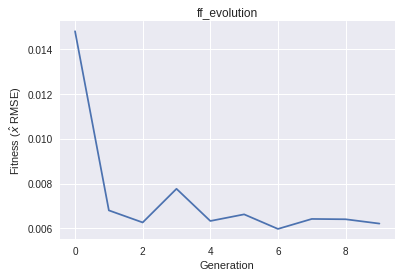

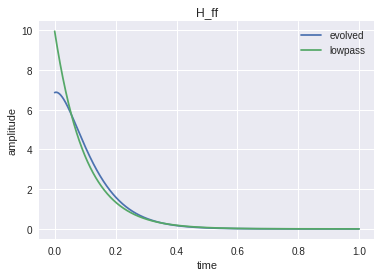

In [300]:
t_train = 1.0
n_processes = 10
evo_popsize = 10
evo_gen_feedforward = 10
evo_seed = 1
zeros_init = [1e2]
poles_init = [-1e2, -1e2]
zeros_delta = [1e1]
poles_delta = [1e1, 1e1]

zeros_ff, poles_ff, d_ff_evo, d_inter_evo = train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedforward,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    network.probe_bio_activity,
    network.probe_oracle)
H_ff_evo = build_filter(zeros_ff, poles_ff)

### Feedback inter spikes with d_inter_oracle, filter bio spikes with either H_ff_evo or Lowpass, and compute new d_ff for each case

In [301]:
t_train = 10.0

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_lowpass = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_evo,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=H_ff_evo
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_H_ff_evo = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


### Remove training spikes, compare test performance under various d_ff, d_fb, H_ff schemes

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


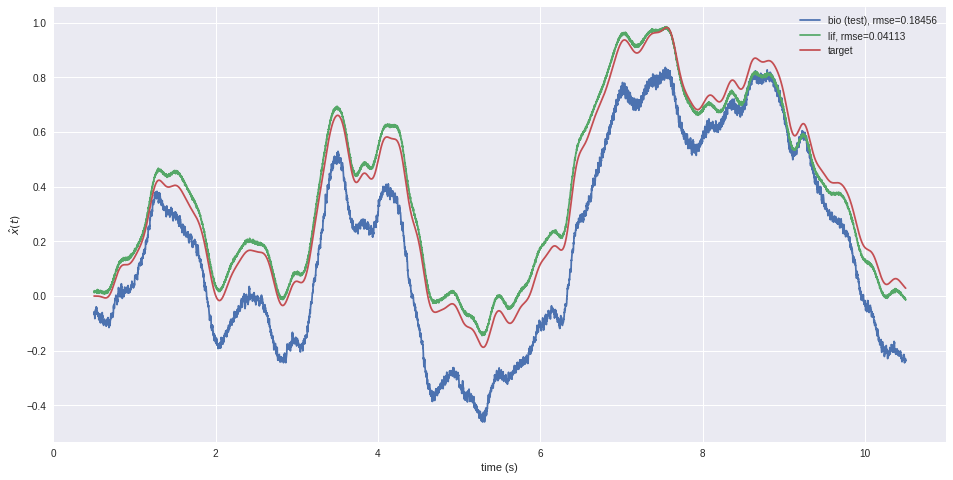

In [302]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_lowpass,
    d_feedback=d_ff_oracle_lowpass,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Default accuracy (no evolutionary filters/decoders)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


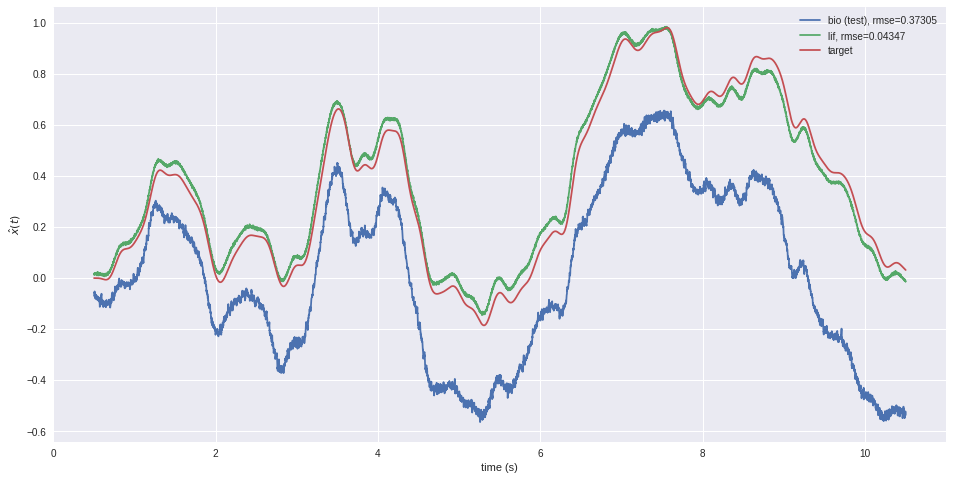

In [303]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_evo,
    d_feedback=d_ff_oracle_H_ff_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Still OK, but worse than the original approach.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


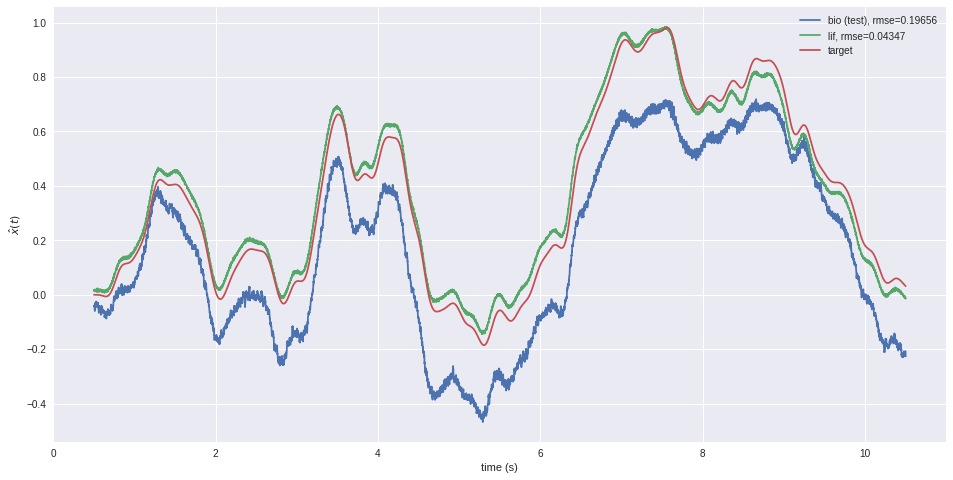

In [305]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_evo,
    d_feedback=d_ff_oracle_lowpass,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Comparable to the original approach.

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


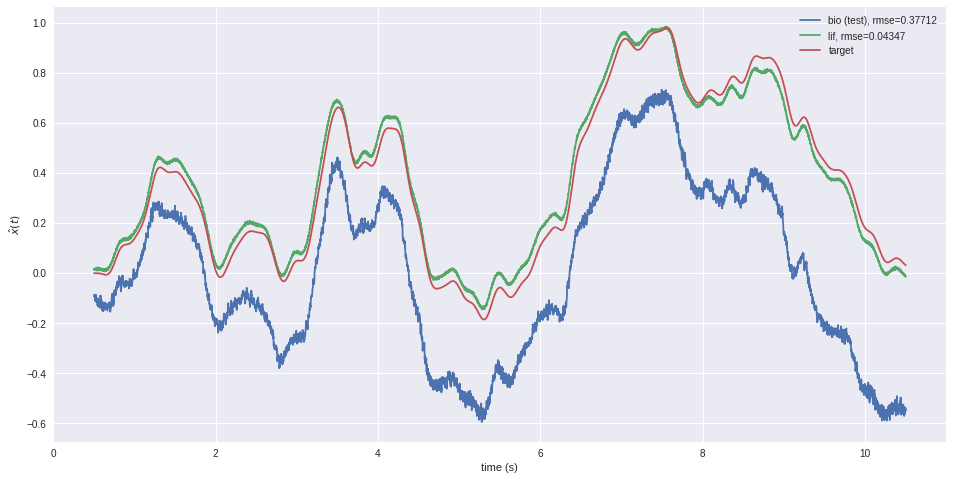

In [307]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_ff_oracle_H_ff_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Seems like using d_fb = d_ff_oracle_H_ff_evo is worse than the standard d_ff_oracle_lowpass, but either one reads out effectively?

### Test best two approaches so far with novel signals

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


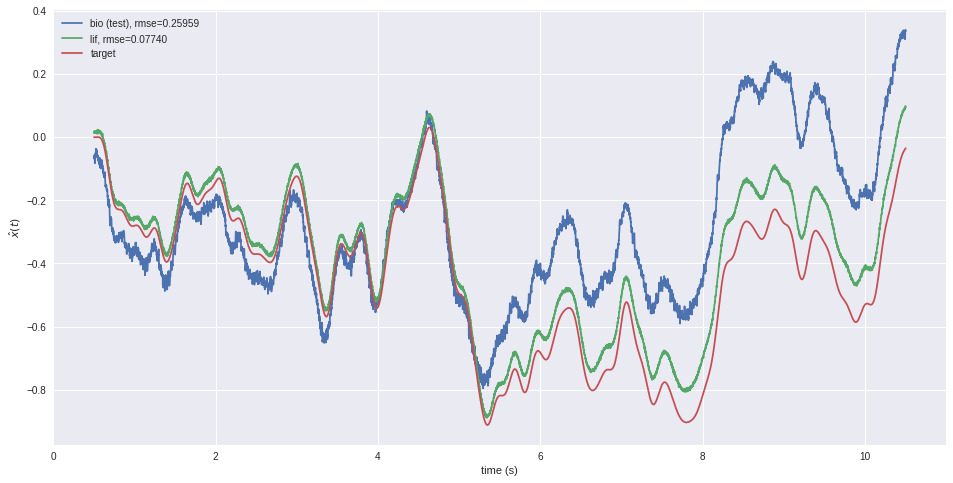

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


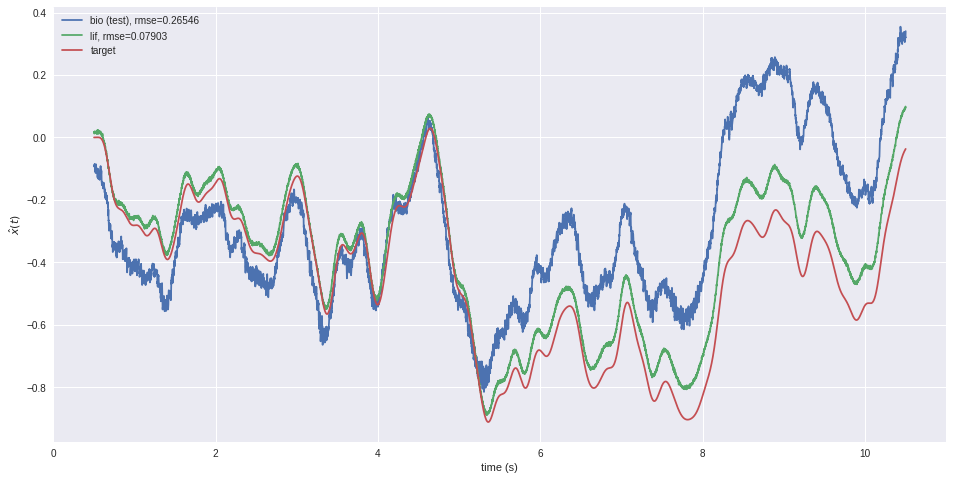

In [308]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_test = 10.0
signal_type_test = 'white_noise'
seed_test = 7

signal_test_3, integral_test_3, transform_test_3 = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_test_3 = tau * transform_test_3

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_3,
    integral=integral_test_3,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_3,
    T_pre_lif=scale_pre_test_3,
    d_feedforward=d_ff_oracle_lowpass,
    d_feedback=d_ff_oracle_lowpass,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_3,
    integral=integral_test_3,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_3,
    T_pre_lif=scale_pre_test_3,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_ff_oracle_H_ff_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Conclusion: an effective method for computing feedback decoders, d_fb, is to:
1. Compute readout decoders d_ff_oracle, using either lowpass filters or evolved filters, for the "bio" and "inter" populations
2. Feed the target signal "integral" into "inter", then send those training spikes to "bio" using d_inter = d_ff_oracle
3. Collect spikes from "bio" in this ideally-stimulated recurrent circuit, then calculate a new set of readout filters d_ff_oracle_2 (again, using either a lowpass or evolved filter)
4. Remove the training spikes and recurrently connect "bio" with d_fb = d_ff_oracle_2, decoding with d_ff = d_ff_oracle_2 as well.

# Evolve d_fb given d_ff

In [309]:
def train_feedback(
    network,
    sim_seed,
    t_transient,
    t_final,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_feedforward,
    d_feedback_init,
    conn_feedback,
    decoders_delta,
    mutation_rate,
    bio_probe,
    target_probe):

    def evaluate(inputs):
        network=inputs[0]
        d_feedback = inputs[1]
        conn_feedback = inputs[2]
        bio_probe = inputs[3][0]
        zeros_feedforward = inputs[3][1]
        poles_feedforward = inputs[3][2]
        d_feedforward = inputs[3][3]
        target_probe = inputs[4]
        plot = inputs[5]

        """ set the readout filter and the recurrent bioneuron decoders"""
        filt = build_filter(zeros_feedforward, poles_feedforward)
        with network:
            bio_probe.synapse = filt
            conn_feedback.solver = nengo.solvers.NoSolver(d_feedback)
            # conn_feedback.solver.decoders_bio = d_feedback
        """
        run the simulation, collect filtered activites,
        and apply the oracle method to calculate readout decoders
        """
        with nengo.Simulator(network, dt=dt, progress_bar=False, seed=sim_seed) as sim:
            sim.run(t_transient+t_final)
        act_bio = sim.data[bio_probe][int(t_transient/dt):]
        target = sim.data[target_probe][int(t_transient/dt):]
        xhat_bio = np.dot(act_bio, d_feedforward)
        rmse_bio = rmse(target, xhat_bio)

        if plot:
            import matplotlib.pyplot as plt
            figure, ax1 = plt.subplots(1,1)
            ax1.plot(sim.trange()[int(t_transient/dt):], xhat_bio, label='bio, rmse=%.5f' %rmse_bio)
            ax1.plot(sim.trange()[int(t_transient/dt):], target, label='oracle')
            ax1.set(xlabel='time (s)', ylabel='activity', title='fb_decodes')
            ax1.legend()
            plt.show()

        return rmse_bio

#     pool = mp.ProcessingPool(nodes=n_processes)
    rng = np.random.RandomState(seed=evo_seed)

    """ Initialize evolutionary population """
    decoder_pop = []
    for p in range(evo_popsize):
        # my_decoders = rng.uniform(-10*decoders_delta, 10*decoders_delta, size=d_feedback_init.shape)
        # my_decoders = d_feedback_init + rng.uniform(-decoders_delta, decoders_delta, size=d_feedback_init.shape)
        d_feedback_delta = rng.normal(0, decoders_delta, size=d_feedback_init.shape)
        for dec in range(d_feedback_delta.shape[0]):
            for dim in range(d_feedback_delta.shape[1]):
                if rng.uniform(0.0, 1.0) > mutation_rate: # set to zero with prob = 1-mutation_rate
                    d_feedback_delta[dec][dim] = 0.0
        my_decoders = d_feedback_init + d_feedback_delta
        decoder_pop.append(my_decoders)

    """ Run evolutionary strategy """
    fit_vs_gen = []
    for g in range(evo_gen):
        print 'generation %s' %g
        # reconfigure nengolib synapses to have propper attributes to be passed to pool.map()
        for probe in network.probes:
            if isinstance(probe.synapse, LinearSystem):
                try:
                    probe.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    probe.synapse.tau = 0.1
                    probe.synapse.default_size_in = 1
                    probe.synapse.default_size_out = 1
                except:
                    continue
        for conn in network.connections:
            if isinstance(conn.synapse, LinearSystem):
                try:
                    conn.synapse._paramdict = nengo.Lowpass(0.1)._paramdict
                    conn.synapse.tau = 0.1
                    conn.synapse.default_size_in = 1
                    conn.synapse.default_size_out = 1
                except:
                    continue
        readout_info = [bio_probe, zeros_feedforward, poles_feedforward, d_feedforward]
        inputs = [[network, decoder_pop[p], conn_feedback, readout_info, target_probe, False] for p in range(evo_popsize)]
        fitnesses = np.zeros((evo_popsize))
        for i, inpt in enumerate(inputs):
            fitnesses[i] = evaluate(inpt)
#         fitnesses = np.array(pool.map(evaluate, inputs))
        best_decoders = decoder_pop[np.argmin(fitnesses)]
        best_fitness = fitnesses[np.argmin(fitnesses)]
        fit_vs_gen.append([best_fitness])
        decay = np.exp(-g / 30.0)
        # decay = 1.0  # off
        """ repopulate decoders pops with mutated copies of the best individual """
        decoders_pop_new = []
        for p in range(evo_popsize):
            # my_decoders = best_decoders + rng.uniform(-decoders_delta, decoders_delta, size=best_decoders.shape) * decay
            # my_decoders = best_decoders + rng.normal(0, decoders_delta, size=best_decoders.shape) * decay
            d_feedback_delta = rng.normal(0, decoders_delta, size=d_feedback_init.shape) * decay
            for dec in range(d_feedback_delta.shape[0]):
                for dim in range(d_feedback_delta.shape[1]):
                    if rng.uniform(0.0, 1.0) > mutation_rate: # set to zero with prob = 1-mutation_rate
                        d_feedback_delta[dec][dim] = 0.0
            my_decoders = best_decoders + d_feedback_delta
            decoders_pop_new.append(my_decoders)
        decoder_pop = decoders_pop_new

    """ Grab the best recurrent decoders and plot training accuracy and fitness vs generation """
    d_feedback = best_decoders
    evaluate([network, d_feedback, conn_feedback, readout_info, target_probe, True])

    fit_vs_gen = np.array(fit_vs_gen)
    import matplotlib.pyplot as plt
    figure, ax1 = plt.subplots(1,1)
    ax1.plot(np.arange(0, evo_gen), fit_vs_gen)
    ax1.set(xlabel='Generation', ylabel='Fitness ($\hat{x}$ RMSE)', title='evolution')
    ax1.legend()
    plt.show()

    return d_feedback

### Compute d_ff and d_fb as above

In [317]:
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train, integral_train, transform_train = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, transform_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_train = tau * transform_train
scale_pre_test = tau *transform_test

In [318]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]
d_feedforward_eval_points = sim.data[network.conn_lif].weights.T
d_inter_eval_points = sim.data[network.conn_inter].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]
d_inter_oracle = nengo.solvers.LstsqL2(reg=reg)(act_inter, integral)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


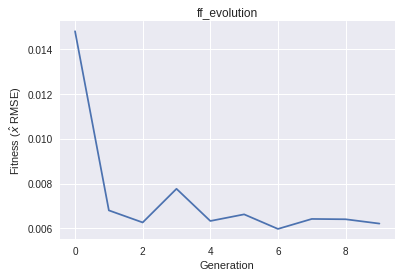

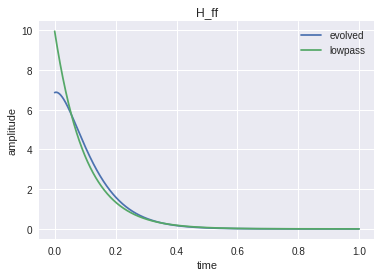

In [319]:
t_train = 1.0
n_processes = 10
evo_popsize = 10
evo_gen_feedforward = 10
evo_seed = 1
zeros_init = [1e2]
poles_init = [-1e2, -1e2]
zeros_delta = [1e1]
poles_delta = [1e1, 1e1]

zeros_ff, poles_ff, d_ff_evo, d_inter_evo = train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedforward,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    network.probe_bio_activity,
    network.probe_oracle)
H_ff_evo = build_filter(zeros_ff, poles_ff)

In [320]:
t_train = 10.0

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_lowpass = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=0.0,
    T_inter_bio=1.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_evo,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=d_inter_oracle,
    H_ff=H_ff_evo
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_train)

act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
d_ff_oracle_H_ff_evo = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


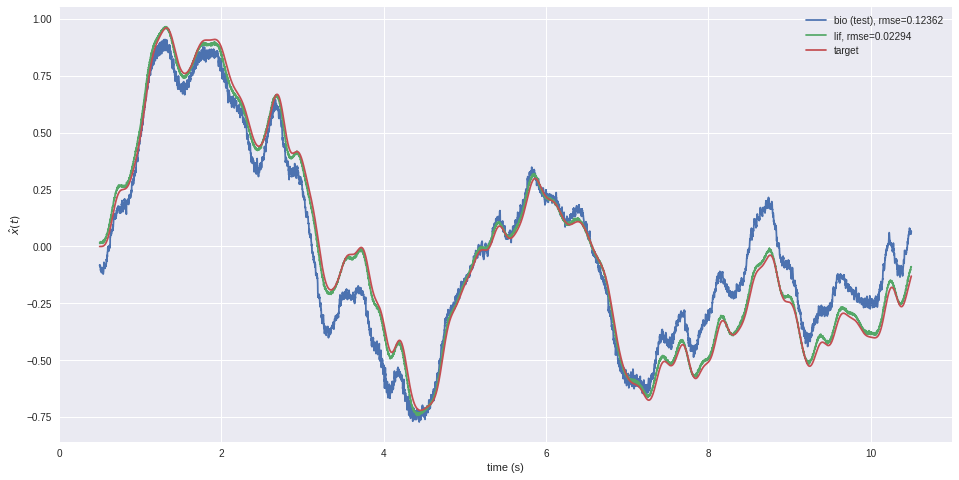

In [321]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_ff_oracle_H_ff_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

### Initial guess at d_fb = d_ff_oracle_H_ff_evo

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


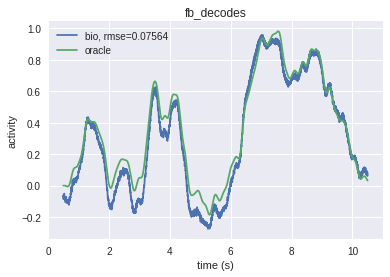

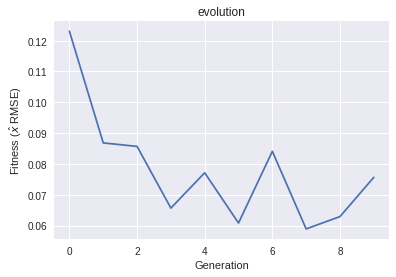

In [331]:
evo_popsize = 10
evo_gen_feedback = 10
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.3
t_train = 10.0

d_ff = d_ff_oracle_H_ff_evo
d_fb_init = d_ff_oracle_H_ff_evo
zeros_feedforward = zeros_ff
poles_feedforward = poles_ff

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


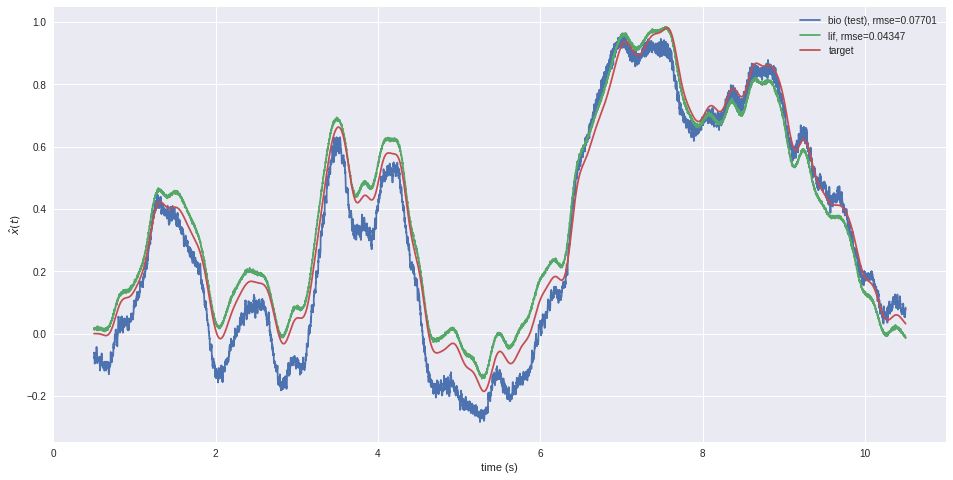

In [333]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Definite improvement in performance. Continue evolving from this point.

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


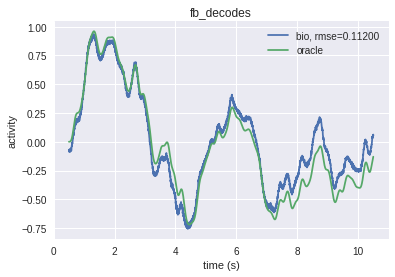

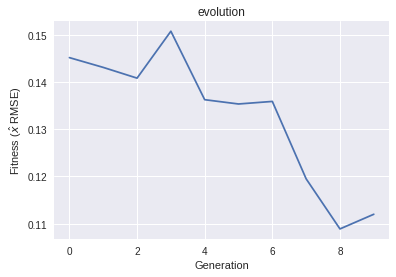

In [334]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_ff_oracle_H_ff_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

evo_popsize = 10
evo_gen_feedback = 10
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.1
t_train = 10.0

d_ff = d_ff_oracle_H_ff_evo
d_fb_init = d_fb_evo
zeros_feedforward = zeros_ff
poles_feedforward = poles_ff

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


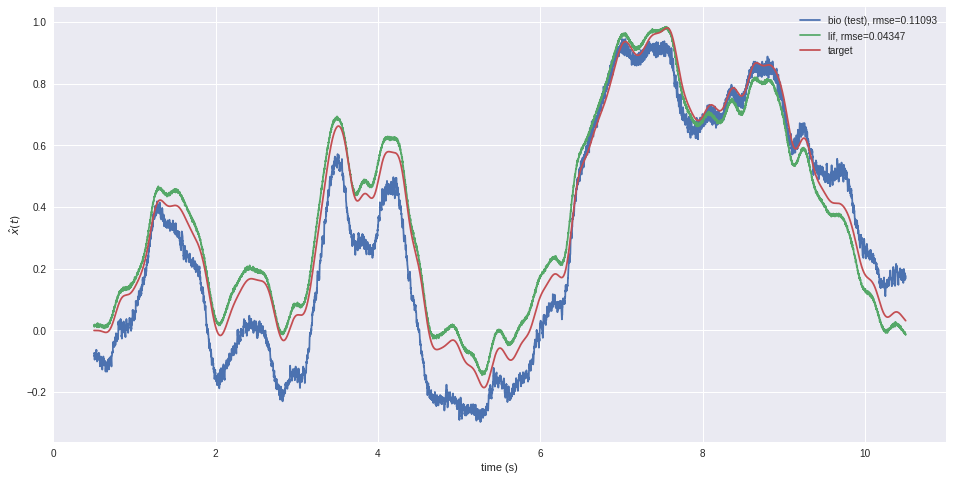

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:13.                                                 


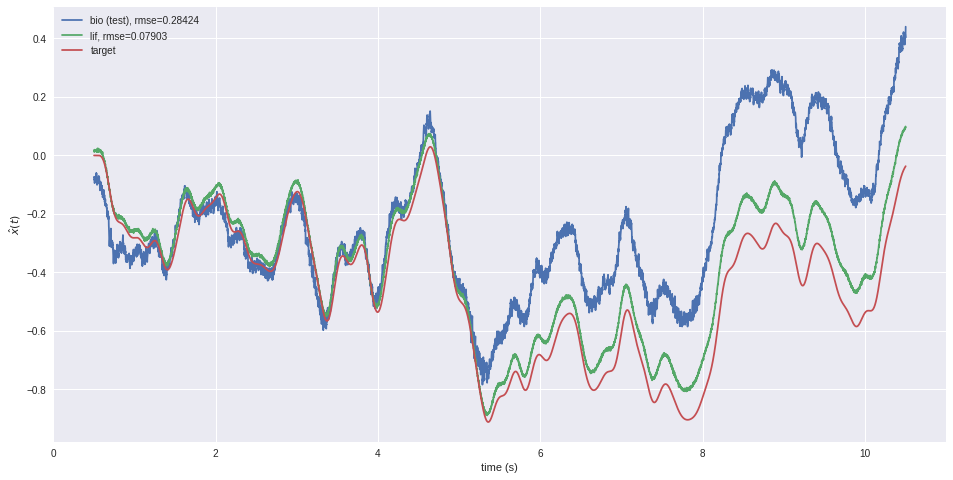

In [337]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test_3,
    integral=integral_test_3,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_3,
    T_pre_lif=scale_pre_test_3,
    d_feedforward=d_ff_oracle_H_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

The evolution of d_fb seems to have worked, though it's tendency to drift is more severe than normal LIFs

# End ====================================

### Begin evolution with d_ff = d_fb_init=d_ff_oracle, trained on ff network

In [819]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

In [820]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


In [821]:
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_ff_eval_points = sim.data[network.conn_lif].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Test initial accuracy with d_fb = d_ff = d_ff_oracle on signal_test and signal_train

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


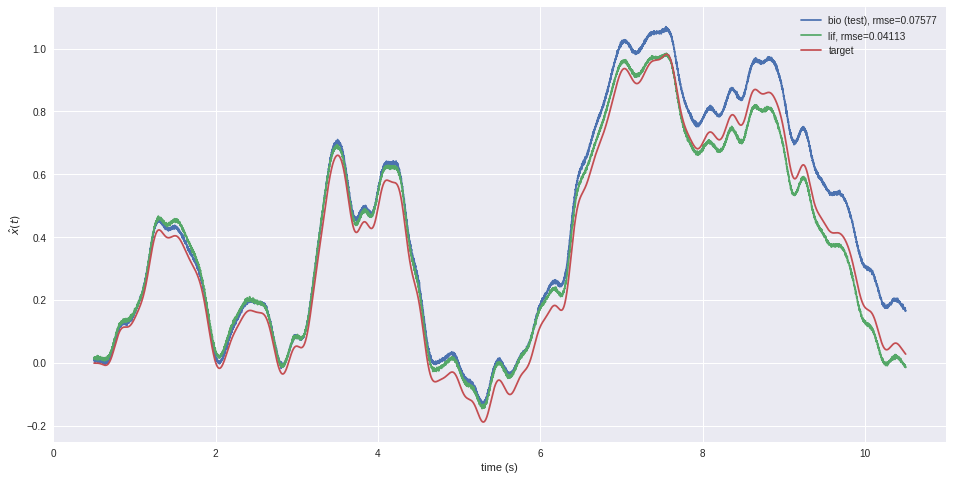

In [822]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


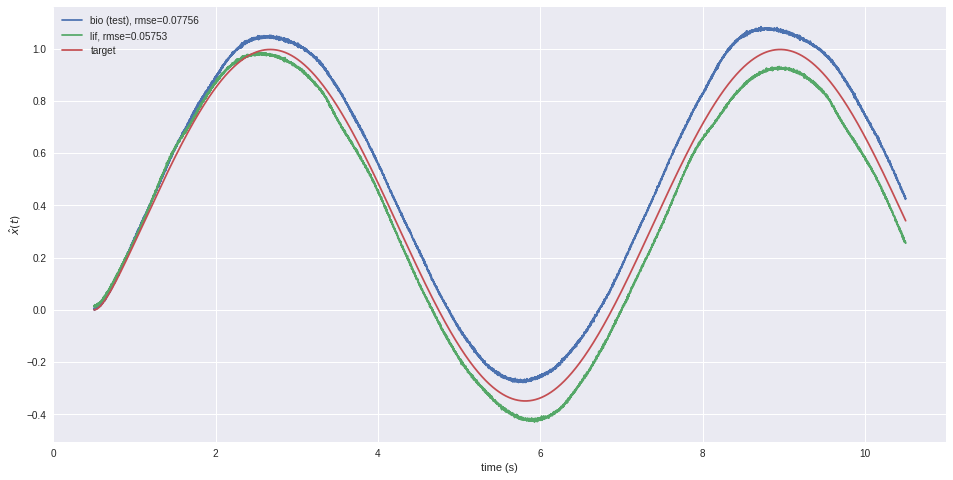

In [832]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Accuracy is already surprisingly good. Now try to further evolve d_fb.

generation 0
generation 1
generation 2


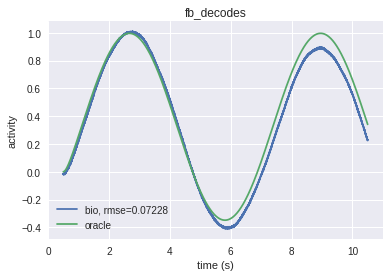

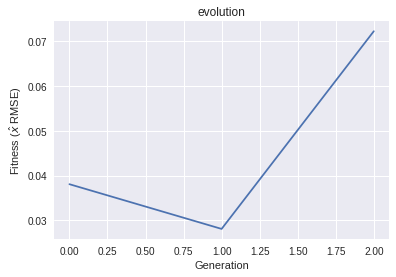

In [833]:
evo_popsize = 10
evo_gen_feedback = 3
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.2
t_train = 10.0

d_ff = d_ff_oracle # d_feedforward_eval_points #
d_fb_init = d_ff_oracle # d_feedforward_eval_points #
zeros_feedforward = []
poles_feedforward = [-1.0/tau_readout]

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


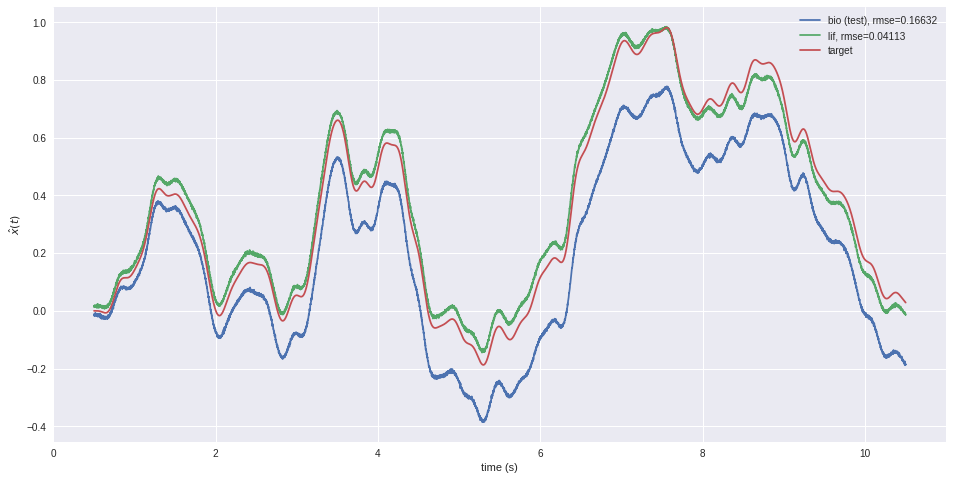

In [834]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_feedforward_eval_points,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

On the right track, but more training is needed.

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19


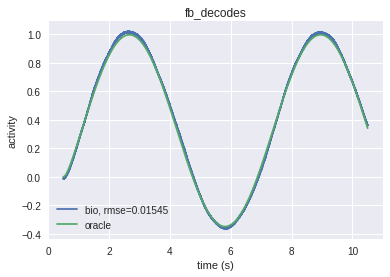

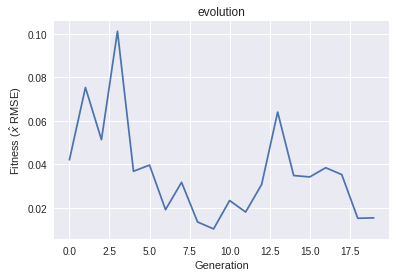

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


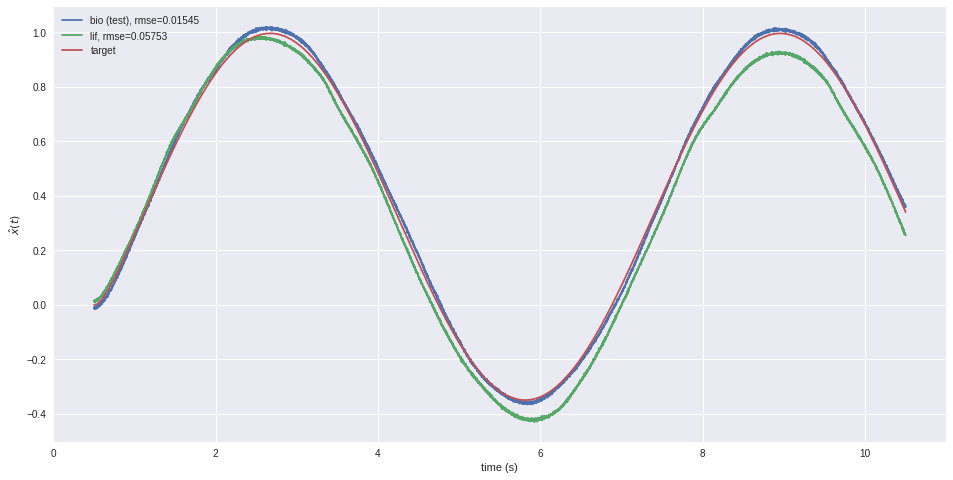

In [835]:
network = make_network(
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

evo_popsize = 10
evo_gen_feedback = 20
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.3
t_train = 10.0

d_ff = d_ff_oracle
d_fb_init = d_fb_evo
zeros_feedforward = []
poles_feedforward = [-1.0/tau_readout]

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


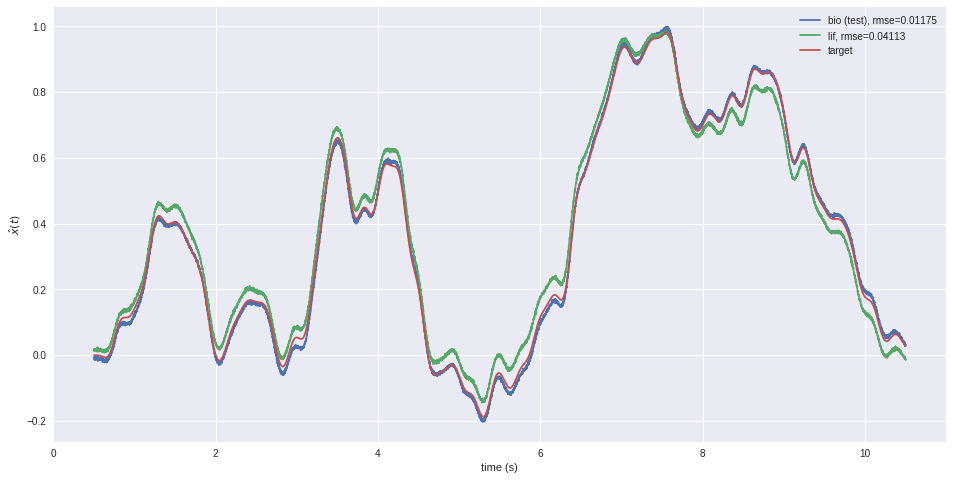

In [836]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Great! Test with an alternate white noise signal

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


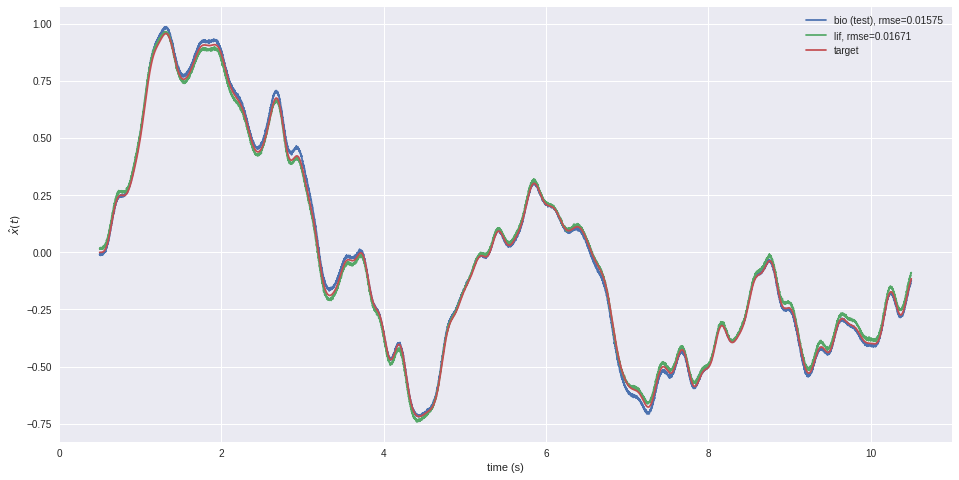

In [842]:
seed_test_2 = 3
signal_test_2, integral_test_2, transform_test_2 = get_signals(
    'white_noise', network_seed, sim_seed, freq, seed_test_2, t_transient, t_test, 5, 0.5, tau, dt)
scale_pre_test_2 = tau * transform_test_2

network = make_network(
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Let's try another seed just to be sure

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:07.                                                 


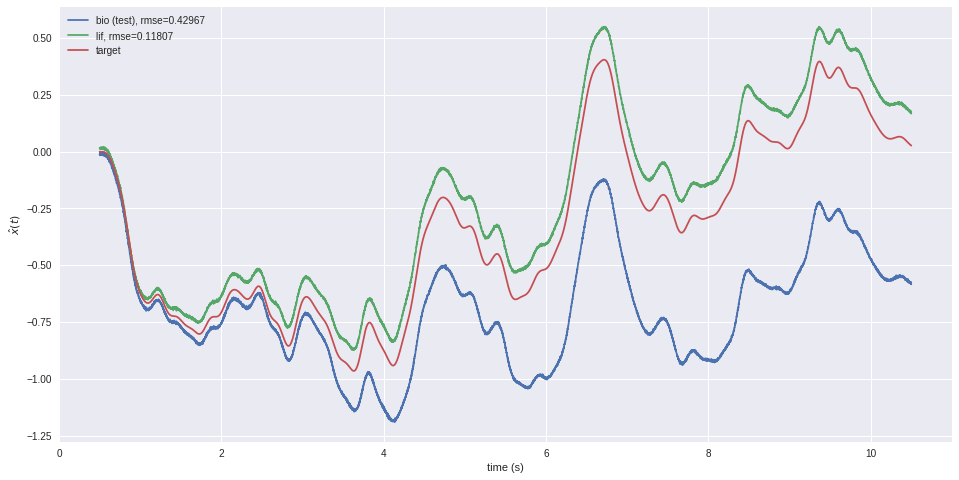

In [843]:
seed_test_2 = 1
signal_test_2, integral_test_2, transform_test_2 = get_signals(
    'white_noise', network_seed, sim_seed, freq, seed_test_2, t_transient, t_test, 5, 0.5, tau, dt)
scale_pre_test_2 = tau * transform_test_2

network = make_network(
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

I wonder why some seeds are so much worse...

### Evolve d_fb with ALIFs

In [845]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),    
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_ff_eval_points = sim.data[network.conn_lif].weights.T
d_ff_oracle = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


In [ ]:
network = make_network(
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_oracle,
    d_feedback=d_ff_oracle,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

run_plot(network, t_transient, t_test, dt, sim_seed)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19


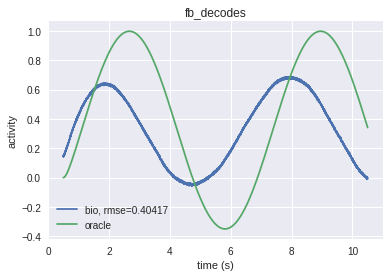

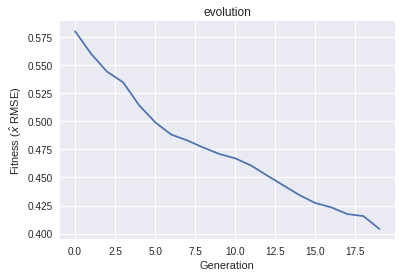

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


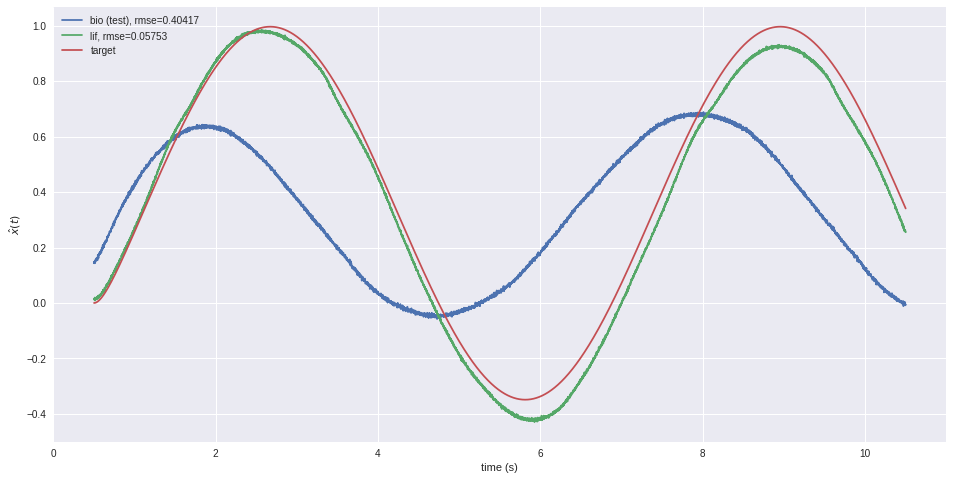

In [846]:
evo_popsize = 10
evo_gen_feedback = 20
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.3
t_train = 10.0

d_fb_init = d_ff_oracle
zeros_feedforward = []
poles_feedforward = [-1.0/tau_readout]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),      
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=d_fb_init,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_feedforward,
    poles_feedforward,
    d_ff_oracle,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

run_plot(network, t_transient, t_test, dt, sim_seed)

Looks like phase shift is going to be a problem for the ALIFs, even with more training? Try evolving H_ff first.

generation 0
generation 1
generation 2
generation 3
generation 4


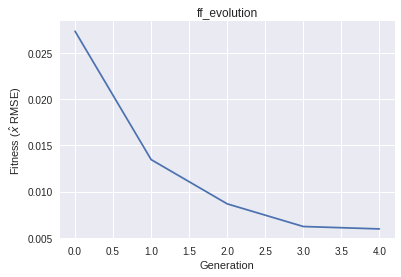

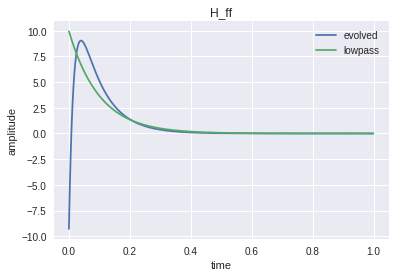

In [857]:
evo_popsize = 10
evo_gen_feedforward = 5
evo_seed = 1
zeros_init = [1e2]
poles_init = [-1e2, -1e2]
zeros_delta = [1e1]
poles_delta = [1e1, 1e1]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

zeros_ff, poles_ff, d_ff_evo, d_inter_evo = train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedforward,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    network.probe_bio_activity,
    network.probe_oracle)
H_ff_evo = build_filter(zeros_ff, poles_ff)

Test feedforward and feedback (d_fb = d_ff_lowpass) accuracy of the decoders

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 
Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


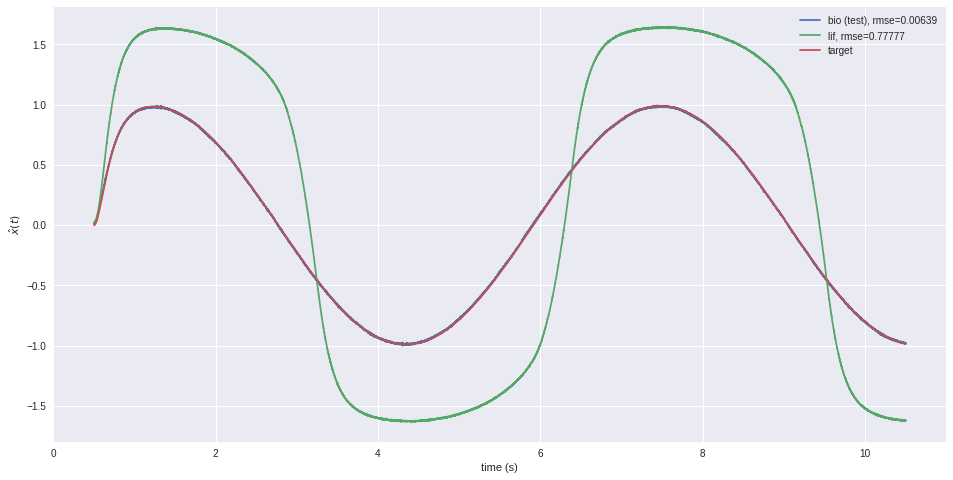

In [858]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_ff_eval_points = sim.data[network.conn_lif].weights.T
d_ff_lowpass = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=d_ff_evo,
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


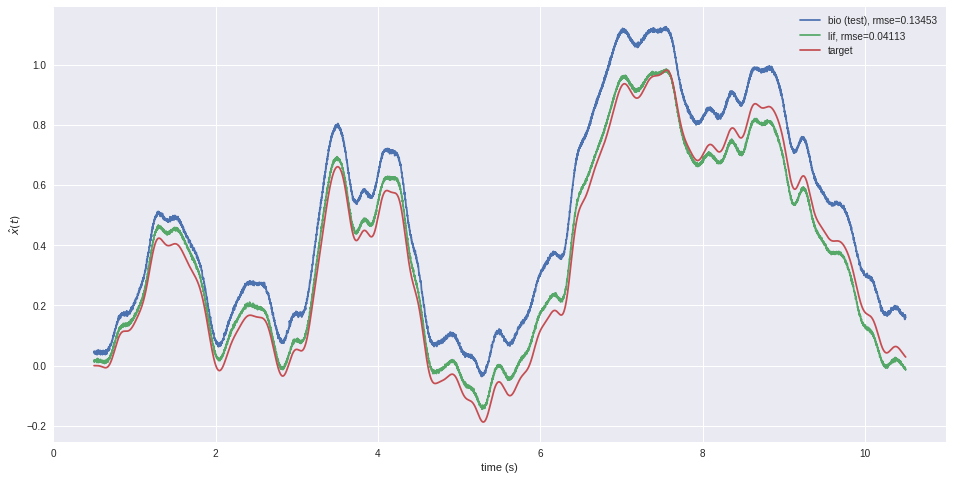

In [859]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_evo,
    d_feedback=d_ff_lowpass,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Train d_fb starting from the (reasonably accurate) d_ff_oracle (computed with nengo.Lowpass rather than evolved H_ff)

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19


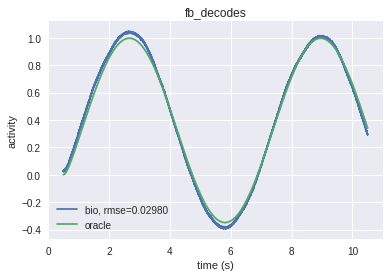

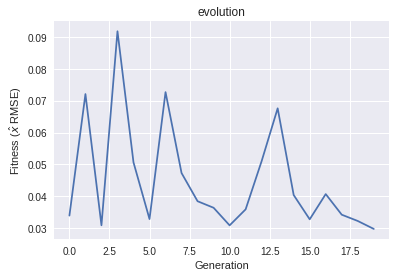

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:08.                                                 


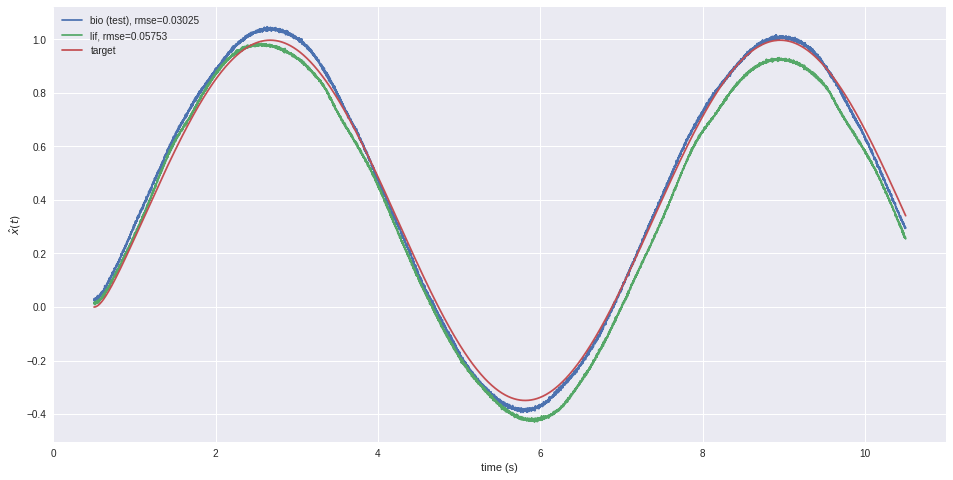

In [860]:
evo_popsize = 10
evo_gen_feedback = 20
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.3
t_train = 10.0

d_fb_init = d_ff_lowpass

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),      
    signal=signal_train,
    integral=integral_train,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train,
    T_pre_lif=scale_pre_train,
    d_feedforward=d_ff_oracle,
    d_feedback=d_fb_init,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff
)

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_ff,
    poles_ff,
    d_ff_oracle,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:11.                                                 


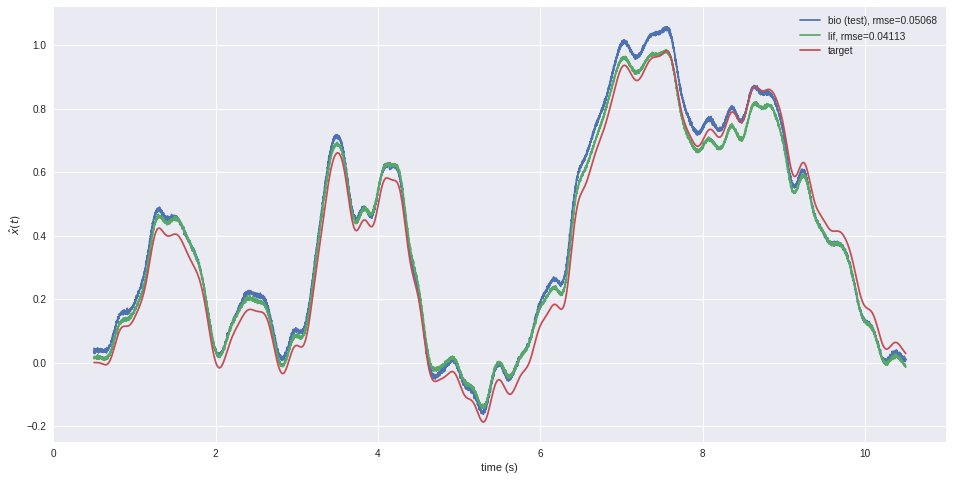

In [863]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


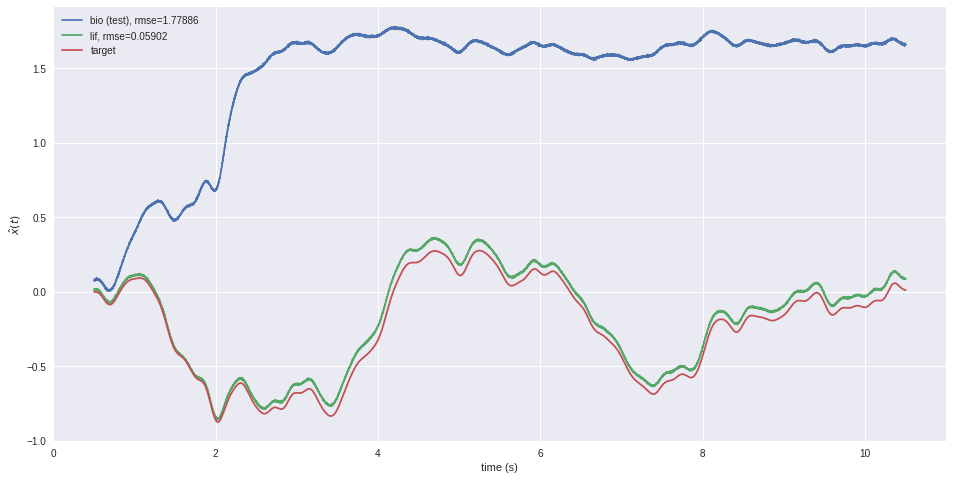

In [867]:
seed_test_2 = 5
signal_test_2, integral_test_2, transform_test_2 = get_signals(
    'white_noise', network_seed, sim_seed, freq, seed_test_2, t_transient, t_test, 5, 0.5, tau, dt)
scale_pre_test_2 = tau * transform_test_2

network = make_network(
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff
)

run_plot(network, t_transient, t_test, dt, sim_seed)

Why are some seeds so much worse, when using d_fb that is evolved on a sinusoid, both for LIF and ALIF?

### Try training ALIFs on a white_noise signal

generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9


/home/pduggins/.virtualenvs/oracle/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


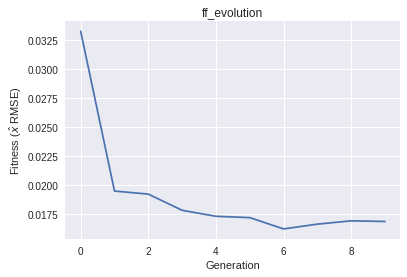

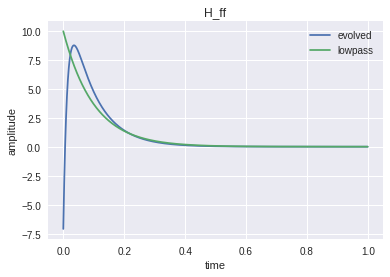

In [18]:
n_processes = 10
freq = 1
max_freq = 5
rms = 0.5
t_transient = 0.5
t_train = 10.0
t_test = 10.0
signal_type_train = 'white_noise'
signal_type_test = 'white_noise'
seed_train = 3
seed_test = 2

signal_train_2, integral_train_2, transform_train_2 = get_signals(
    signal_type_train, network_seed, sim_seed, freq, seed_train, t_transient, t_train, max_freq, rms, tau, dt)
signal_test, integral_test, transform_test = get_signals(
    signal_type_test, network_seed, sim_seed, freq, seed_test, t_transient, t_test, max_freq, rms, tau, dt)
scale_pre_train_2 = tau * transform_train_2
scale_pre_test = tau *transform_test

evo_popsize = 10
evo_gen_feedforward = 10
evo_seed = 1
zeros_init = [1e2]
poles_init = [-1e2, -1e2]
zeros_delta = [1e1]
poles_delta = [1e1, 1e1]

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_train_2,
    integral=integral_train_2,
    T_stim_oracle=1.0,
    T_integ_oracle=0.0,
    T_bio_bio=0.0,
    T_inter_bio=0.0,
    T_pre_bio=1.0,
    T_pre_lif=1.0,
    d_feedforward=np.zeros((bio_neurons, dim)),
    d_feedback=np.zeros((bio_neurons, dim)),
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=nengo.Lowpass(tau)
)

zeros_ff, poles_ff, d_ff_evo, d_inter_evo = train_feedforward(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedforward,
    evo_seed,
    zeros_init,
    poles_init,
    zeros_delta,
    poles_delta,
    network.probe_bio_activity,
    network.probe_oracle)
H_ff_evo = build_filter(zeros_ff, poles_ff)

In [19]:
with nengo.Simulator(network, dt=dt, seed=sim_seed) as sim:
    sim.run(t_transient + t_test)
    
act_bio = sim.data[network.probe_bio_activity][int(t_transient/dt):]
act_inter = sim.data[network.probe_inter_activity][int(t_transient/dt):]
target = sim.data[network.probe_oracle][int(t_transient/dt):]
integral = sim.data[network.probe_integ][int(t_transient/dt):]

d_ff_eval_points = sim.data[network.conn_lif].weights.T
d_ff_lowpass = nengo.solvers.LstsqL2(reg=reg)(act_bio, target)[0]

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


generation 0
generation 1
generation 2
generation 3
generation 4
generation 5
generation 6
generation 7
generation 8
generation 9
generation 10
generation 11
generation 12
generation 13
generation 14
generation 15
generation 16
generation 17
generation 18
generation 19
generation 20
generation 21
generation 22
generation 23
generation 24
generation 25
generation 26
generation 27
generation 28
generation 29
generation 30
generation 31
generation 32
generation 33
generation 34
generation 35
generation 36
generation 37
generation 38
generation 39
generation 40
generation 41
generation 42
generation 43
generation 44
generation 45
generation 46
generation 47
generation 48
generation 49


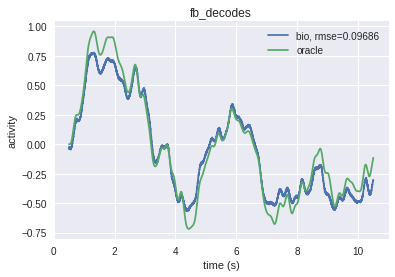

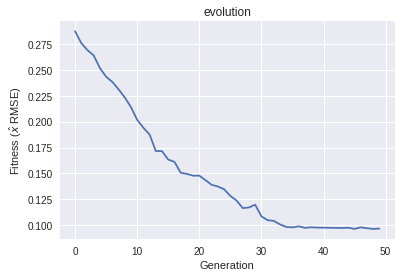

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:12.                                                 


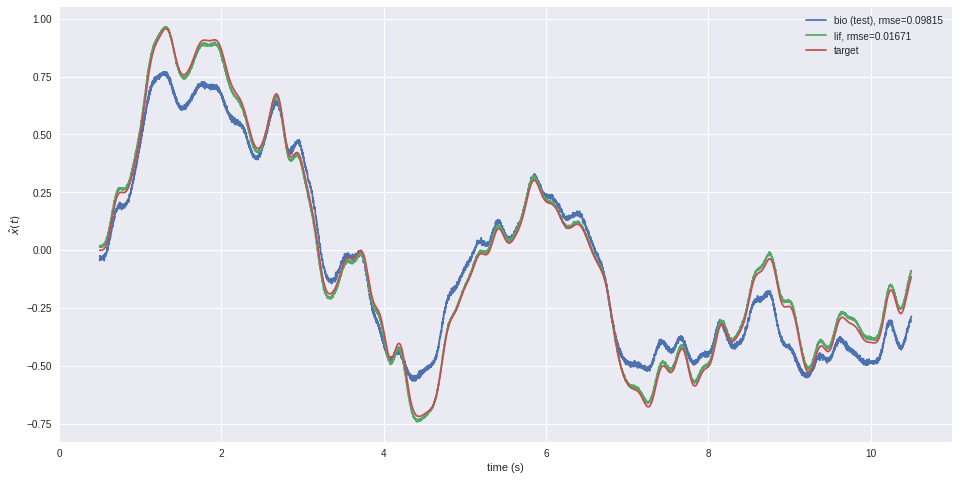

In [25]:
evo_popsize = 10
evo_gen_feedback = 50
evo_seed = 1
decoders_delta = 1e-5
mutation_rate = 0.3
t_train = 10.0

d_fb_init = d_ff_lowpass

network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),      
    signal=signal_train_2,
    integral=integral_train_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_train_2,
    T_pre_lif=scale_pre_train_2,
    d_feedforward=d_ff_evo,
    d_feedback=d_fb_init,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

d_fb_evo = train_feedback(
    network,
    sim_seed,
    t_transient,
    t_train,
    dt,
    reg,
    n_processes,
    evo_popsize,
    evo_gen_feedback,
    evo_seed,
    zeros_ff,
    poles_ff,
    d_ff_evo,
    d_fb_init,
    network.bio_bio,
    decoders_delta,
    mutation_rate,
    network.probe_bio_activity,
    network.probe_oracle)

run_plot(network, t_transient, t_test, dt, sim_seed)

Evolution seems to be succeeding on the training data. How about the test data?

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:09.                                                 


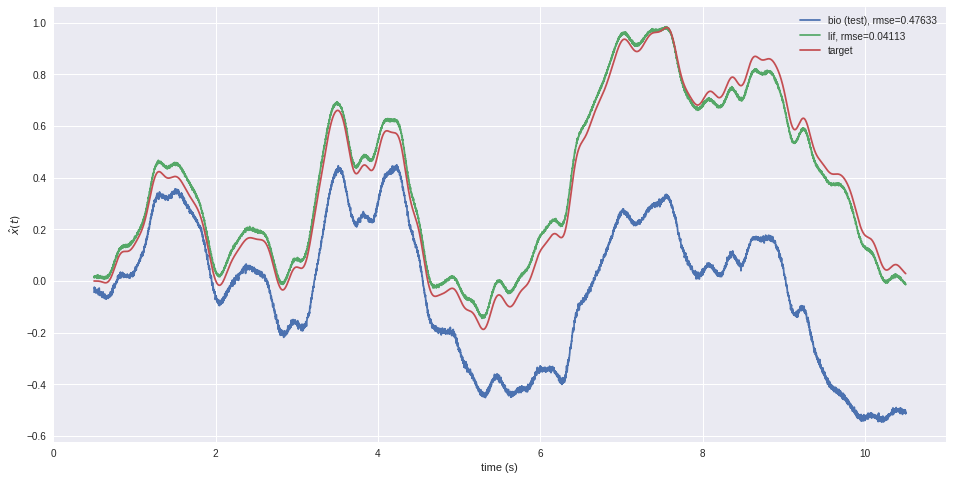

In [26]:
network = make_network(
    bio_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    inter_type=nengo.AdaptiveLIF(tau_n=0.01, inc_n=0.1),
    signal=signal_test,
    integral=integral_test,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test,
    T_pre_lif=scale_pre_test,
    d_feedforward=d_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)

And a 2nd set of test data

Building finished in 0:00:01.                                                   
Simulating finished in 0:00:10.                                                 


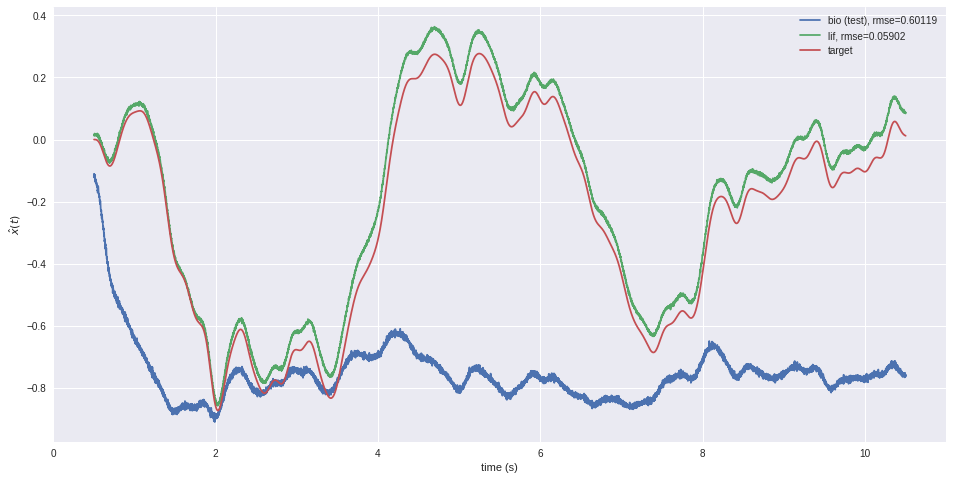

In [28]:
seed_test_2 = 5
signal_test_2, integral_test_2, transform_test_2 = get_signals(
    'white_noise', network_seed, sim_seed, freq, seed_test_2, t_transient, t_test, 5, 0.5, tau, dt)
scale_pre_test_2 = tau * transform_test_2

network = make_network(
    signal=signal_test_2,
    integral=integral_test_2,
    T_stim_oracle=0.0,
    T_integ_oracle=1.0,
    T_bio_bio=1.0,
    T_inter_bio=0.0,
    T_pre_bio=scale_pre_test_2,
    T_pre_lif=scale_pre_test_2,
    d_feedforward=d_ff_evo,
    d_feedback=d_fb_evo,
    d_inter=np.zeros((bio_neurons, dim)),
    H_ff=H_ff_evo
)

run_plot(network, t_transient, t_test, dt, sim_seed)